In [6]:
import sys 
import os 

sys.path.append('../..')

DATA_DIR = '../../data'
os.environ['DATA_DIR'] = DATA_DIR

from utils.correlation import calc_correlation, vectorize_concepts
from utils.data import load_data, load_gpt, load_cslb, load_sorting, load_cslb_count_vec, load_mcrae, generate_concepts_to_keep, match_behv_sim, load_behav

import spacy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

from scipy.spatial.distance import squareform
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import scipy

nlp = spacy.load("en_core_web_sm")

DATA_DIR = 'labels'

# Label Distribution

In [4]:
cslb_df = load_cslb_count_vec()
a = pd.DataFrame(cslb_df.loc['dog']).reset_index().rename(columns={'index': 'feature', 'dog': 'amount'})
a = a.sort_values(by='amount', ascending=False)
a = a[:5]
a['feature'] = a['feature'].apply(lambda feature: feature.replace('_', ' '))
a['label'] = a['feature'].apply(get_feature_label)

a

,feature,amount,label
1054,has fur hair,18.0,conceptual
9,does bark,17.0,encyclopaedic
855,has a tail,16.0,conceptual
1444,is a pet,15.0,taxonomic
1549,is an animal,14.0,taxonomic


In [3]:
colors = {
    'encyclopaedic': '#93C47D',
    'functional': '#FFD966',
    'conceptual': '#6D9EEB',
    'other perceptual': '#FF00FF',
    'visual': '#DD7E6B',
    'taxonomic': '#F6B26B' 
}


In [4]:
gpt_label_df = pd.read_csv('labels/gpt.csv')
cslb_label_df = pd.read_csv('labels/cslb.csv')
mc_label_df = pd.read_csv('labels/mc.csv')

# Test distribution GPT-3 and CSLB

In [7]:
gpt_contigence = gpt_label_df.groupby('label').count()
cslb_contigence = cslb_label_df.groupby('label').count()

a = scipy.stats.chisquare(gpt_contigence, cslb_contigence)
print(a)

Power_divergenceResult(statistic=array([1085.01629315]), pvalue=array([2.34897824e-232]))


In [7]:
def plot(means, ax, confs):
    for value,count in means.items():
        x = []
        y = []
        label = str(value)
        x.append(label)
        y.append(count)
        conf = confs[value]
        
        ax.bar(x, y, color=colors[label], yerr=[conf])
        #ymin, ymax = 0, 0.6
        #ax.set_ylim(ymin, ymax)

defaultdict(None, {'encyclopaedic': 0.12251382192701017, 'functional': 0.12018764015005284, 'conceptual': 0.09724221207729024, 'taxonomic': 0.07230645146020179, 'visual': 0.04663605252257784, 'other perceptual': 0.021851785057609232})
defaultdict(None, {'encyclopaedic': 0.12708816538403844, 'functional': 0.06692565531049165, 'conceptual': 0.11373893604422573, 'taxonomic': 0.07043940914190196, 'visual': 0.06169990033055809, 'other perceptual': 0.03173303094810127})
defaultdict(None, {'encyclopaedic': 0.13047458204859105, 'functional': 0.12100218354557822, 'conceptual': 0.1049586595901773, 'taxonomic': 0.0683813139415394, 'visual': 0.06813651262389568, 'other perceptual': 0.020056588220785734})


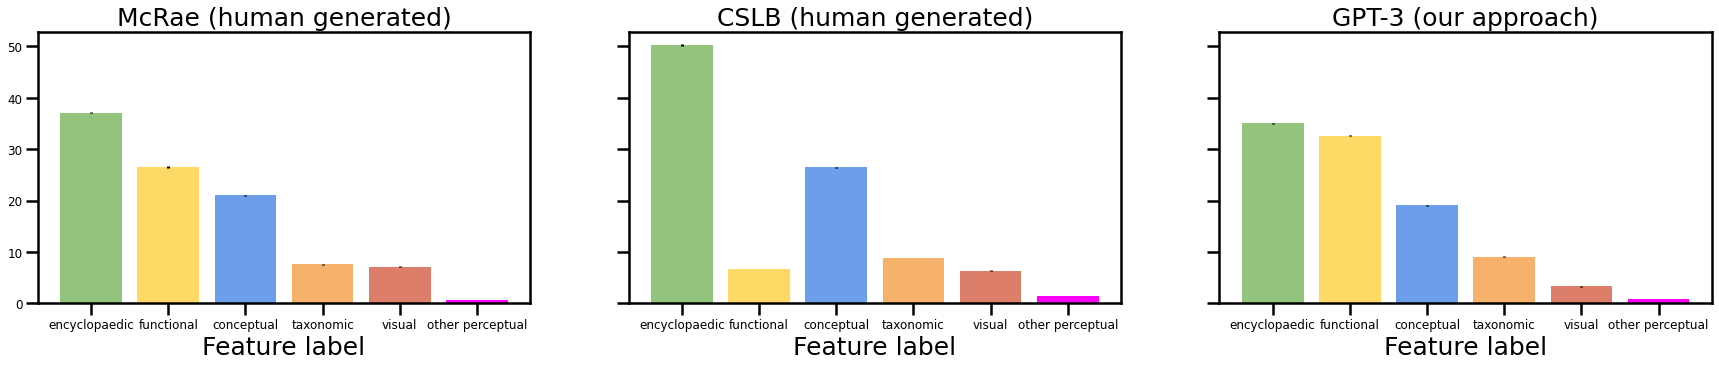

In [8]:
%matplotlib inline
from skimage import io
import cv2
from evaluation.labels import get_feature_label
from matplotlib.pyplot import imshow, text
import statistics
from math import sqrt
from collections import defaultdict

fig, axes = plt.subplots(1,3,figsize=(30,5), sharey=True)

def get_confidence_interval(df):
    values = {
        'encyclopaedic': [],
        'functional': [],
        'conceptual': [], 
        'taxonomic': [],
        'visual': [],
        'other perceptual': []
    }
    confs = defaultdict()
    means = defaultdict()

    for i in range(1000):
        sample = df.sample(1000, replace=True)
        hist = sample['label'].value_counts(dropna=False, normalize=True)
        hist = hist.apply(lambda value: value * 100)
        for label in values:
            if label in hist:
                values[label].append(hist.loc[label])

    for label, label_values in values.items():
        mean = statistics.mean(label_values)
        means[label] = mean
        stdev = statistics.stdev(label_values)
        confidence_interval = 2.575 * stdev / sqrt(len(label_values))
        conf = confidence_interval
        confs[label] = conf

    return confs, means
    

def plot_bar(df, ax, title):
    fontsize = 25
    hist = df['label'].value_counts(dropna=False, normalize=True)
    hist = hist.apply(lambda value: value * 100)
    confs, means = get_confidence_interval(df)
    plot(means, ax, confs)
    print(confs)

    ax.set_title(title, fontsize=fontsize)
    ax.set_xlabel('Feature label', fontsize=fontsize)
    ax.tick_params(labelsize=12)


plot_bar(gpt_label_df, axes[2], 'GPT-3 (our approach)')
plot_bar(cslb_label_df, axes[1], 'CSLB (human generated)')
plot_bar(mc_label_df, axes[0], 'McRae (human generated)')


fig.savefig('labels.svg')
plt.show()